In [5]:
import sys
# import os
# print(os.listdir("../../blackjax"))
# raise Exception("stop")
sys.path.append("../../../../../blackjax")
sys.path.append("../../../../../sampler-benchmarks/sampler-comparison")
import jax
import jax.numpy as jnp
import blackjax
from blackjax.util import run_inference_algorithm
from sampler_comparison.samplers.general import (
    with_only_statistics,
    make_log_density_fn,
)
from sampler_comparison.samplers.nosehoover.unadjusted import unadjusted_nosehoover_no_tuning
from collections import namedtuple

from sampler_comparison.samplers.general import initialize_model

# Minimal model for testing: standard normal in 2d (avoids sampler_evaluation deps)
Model = namedtuple("Model", ["ndims", "log_density_fn", "default_event_space_bijector", "sample_transformations"])
log_density_fn = lambda z: -0.5 * jnp.sum(z**2)
model = Model(
    ndims=2,
    log_density_fn=log_density_fn,
    default_event_space_bijector=lambda x: x,
    sample_transformations={},  # with_only_statistics may expect this
)

key = jax.random.PRNGKey(0)
initial_position = initialize_model(model, key)
key, init_key = jax.random.split(key)

alg = blackjax.nosehoover(
    logdensity_fn=make_log_density_fn(model),
    step_size=0.1,
    inverse_mass_matrix=1.0,
)
initial_state = alg.init(initial_position, init_key)

sampler = unadjusted_nosehoover_no_tuning(
    initial_state=initial_state,
    integrator_type="velocity_verlet",  # unused, for API consistency
    step_size=0.1,
    L=4,
    inverse_mass_matrix=1.0,
    return_samples=True,
    Q=10
)

key, run_key = jax.random.split(key)
num_steps = 2000
samples, meta = sampler(model, num_steps, initial_position, run_key, )



Text(0, 0.5, 'y')

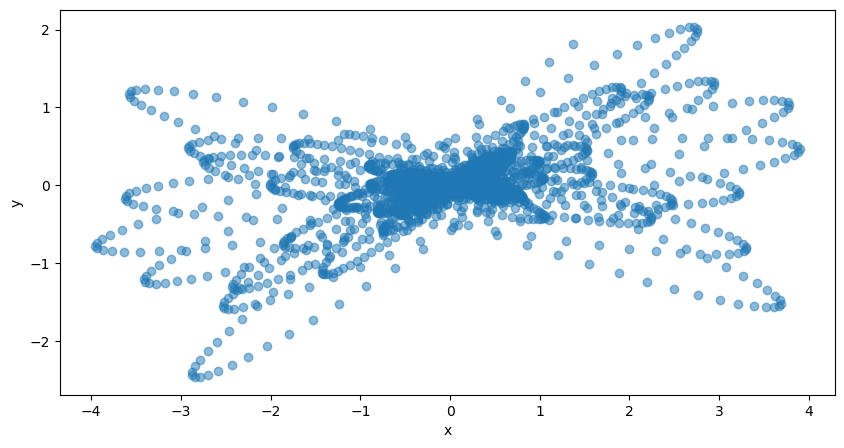

In [6]:
# plot samples
import matplotlib.pyplot as plt

# Plot the samples
plt.figure(figsize=(10, 5))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')